# W + Charm Analysis:

This analysis is done using `Coffea` (version 2024.10.0) and `Awkward Arrays`. This study will focus on the event selection of W+c Events. This analysis will focus on the selection of W+c Events for c-tagging study. The dataset used for this is: [W1JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL16NanoAODv9-106X_mcRun2_asymptotic_v17-v1/NANOAODSIM](https://opendata.cern.ch/record/69545).

## Measurement of W + charm production:

In the LHC, large number of pp-collisions containing events with a vector boson(V) accompanied by one or more heavy-flavour jets(HF) are produced. These V+HF events can be used to study specific predictions of the SM. Also V+HF contribute to the backgrounds of to many other processes like Higgs production (Z+b), top-physics (W+b) and beyond SM processes.

This study is of the associated production of a W boson and a charm(c) quark at the LHC. This provides direct access to strange quark content of the proton at the W-boson mass energy scale. This sensitivity is due to dominance of $\bar{q}g \rightarrow W^{+} + \bar{c}$ and $qg \rightarrow W^{-} + c$ contibutions at hard scattering level. Due to the presence of down valence quarks in the proton, the production yield of $W^{-} + c$ is expected to be slightly larger than $W^{+} + c$.

## Key Idea:

The rate depends directly on the strange content because the dominant subprocess needs a $s$ or $\bar{s}$ quark to turn into a $charm$ quark via a $W$-boson.  


In [50]:
import hist as h
import dask
import awkward as ak
import hist.dask as dhist
import dask_awkward as dak
import uproot
import numpy as np
import mplhep as mh
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import apply_to_fileset, preprocess
from matplotlib import pyplot as plt

In [51]:
events = NanoEventsFactory.from_root(
    {"../../datasets/nano106X_on_mini106X_2017_mc_NANOAOD_W1Jets_to_LNu_250K.root": "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset":"WJets"},
    mode="dask"
).events()
events

/home/xondikoi/miniconda3/envs/Coffea_2025/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea_2025/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/home/xondikoi/miniconda3/envs/Coffea_2025/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


dask.awkward<from-uproot, npartitions=1>

In [52]:
# Defining the style for plots (CMS Style)
plt.style.use(mh.style.CMS)
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Histogram Function:
def make_hist(data, nBins, lo, hi, xLabel, yLabel, label, fname=None, logy=False):
    histogram = dhist.Hist(h.axis.Regular(nBins, lo, hi))
    fig, ax = plt.subplots(1 ,1, figsize=(6,4))
    histogram.fill(data)
    # histogram.compute().plot(ax=ax , yerr=False, label=label)  
    mh.histplot(histogram.compute(), ax=ax, label=label, yerr=False, histtype="step") 
    mh.cms.label("Open Data", data=True, lumi=None, com=13, year=2016, loc=0)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.legend()
    if logy:
        ax.set_yscale("log")
    if fname:
        plt.savefig(fname)
    plt.show()

## W $\rightarrow$ $\mu + \nu$ Event Selection:

This part of the notebook selects all the events that pass the following cuts:
- Muon $p_{T}$ > 35 GeV
- Muon $\eta$ < 2.4
- Muon_pfRelIso04_all < 0.15
- $M_{T}$ > 55 GeV

`Muon_pfRelIso04_all` represents the relative isolation of a reconstructed muon within the cone radius of $\Delta R$ = 0.4 around the muon. Higher value suggests the muon is likely from a jet (muon is not isolated) and lower value suggests the muon is likely from a $W/Z$ decay. 

In [53]:
# RecoMuons and MET:
RecoMuons = events.Muon
MET = events.MET

# Muon Selection Cuts: 
Selection_Cuts = (
    (RecoMuons.pt > 35) &
    (abs(RecoMuons.eta) < 2.4) &
    (abs(RecoMuons.pfRelIso04_all) < 0.15) &
    (RecoMuons.tightId == 1)
)

# M_T Selection Cut:
Muon_Mt = np.sqrt(2 * RecoMuons.pt * MET.pt * (1 - np.cos(RecoMuons.phi - MET.phi)))
Selection_Cuts = Selection_Cuts & (Muon_Mt > 55)
Muons_Sel = RecoMuons[Selection_Cuts]

# Leading Muon Collection and Transverse Momentum:
Leading_Muons = dak.firsts(Muons_Sel)
none_val_mask = dak.is_none(Leading_Muons.pt) # all None values
Leading_Muons_Clean = Leading_Muons[~none_val_mask] # discard all none values
Leading_Muons_Clean_Pt = Leading_Muons_Clean.pt

# Number of Sorted Muons & passCuts for OS:
nMuons = dak.num(Muons_Sel)

# Sub-Leading Muon Collection and Transverse Momentum:
sublead_mask = nMuons > 1
Subleading_Muons = Muons_Sel[sublead_mask][:,1]

OS_mask = (ak.sum(Muons_Sel.charge, axis=1) == 0) | (nMuons >=2) 
Selected_Muons_PassCuts = ~OS_mask 
 # Final Selection of Muons:
fMuons = Muons_Sel[Selected_Muons_PassCuts]

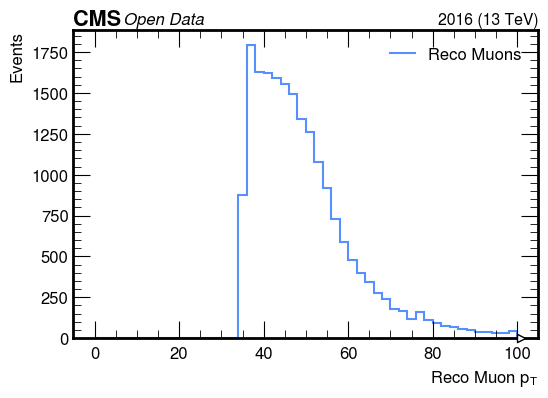

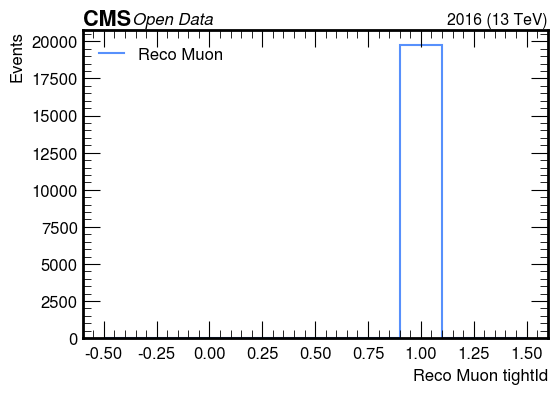

In [54]:
Muon_sel_pt = dak.flatten(Muons_Sel.pt)
make_hist(
    Muon_sel_pt,
    50, 0, 100,
    "Reco Muon $p_{T}$",
    "Events",
    "Reco Muons",
    fname="Plots/Reco_Muon_pt.png",
    logy=False
)
Muon_sel_tightId = dak.flatten(Muons_Sel.tightId)
make_hist(
    Muon_sel_tightId,
    10, -0.5, 1.5,
    "Reco Muon tightId",
    "Events",
    "Reco Muon",
    fname=None,
    logy=False
)

> **Note:** The cuts of $p_{T}$ > 35 GeV and the `Muon_tightId` == 1 gives us perfect cuts. But there is a strange thing that happens with the selection cuts applied to the next part!

Here I am trying to make a selection of all the events that pass the above selection cuts rather than making a singular physics object collection like - RecoMuons that pass the selection cuts.

In [55]:
# Let's see if we can do this in another way:
Sel_Cuts = (
    (events.Muon.pt > 35) &
    (abs(events.Muon.eta) < 2.4) &
    (abs(events.Muon.pfRelIso04_all) < 0.15) &
    (events.Muon.tightId == 1)
)
Mu_Mt = np.sqrt(2 * events.Muon.pt * events.MET.pt * (1 - np.cos(events.Muon.phi - events.MET.phi)))
Sel_Cuts = Sel_Cuts & (Mu_Mt > 55)
Sel_Cuts = dak.any(Sel_Cuts, axis=1)
pass_events = events[Sel_Cuts]

# Leading Muon Collection and Transverse Momentum:
Leading_Muons = dak.firsts(pass_events.Muon)
none_val_mask = dak.is_none(Leading_Muons.pt) # all None values
Leading_Muons_Clean = Leading_Muons[~none_val_mask] # discard all none values
Leading_Muons_Clean_Pt = Leading_Muons_Clean.pt

# Pt of Muon passing the cuts:
pass_events_Muon_Pt = pass_events.Muon.pt

# Number of Muons passing the cuts:
nPassMuons = dak.num(pass_events_Muon_Pt)
Muon_charge = pass_events.Muon.charge
OS_Mask = (
    (dak.sum(Muon_charge, axis=1) == 0) |
    (nPassMuons >= 2)
    )
finMask = ~OS_Mask
WBoson_Events = pass_events[finMask]

I want to make some comparison between: 
- Standalone physics object collection: `fMuons` and
- Collection of all events that pass the event selection cuts for W-Bosons: `WBoson_Events`

In the `fMuons` collection, there are 21520 events that pass the selection cuts out of 250K, while in the `WBoson_Events`, 19256 events passed the selection cuts. 

## Plots: `fMuons` vs `WBoson_Events`:

I will make plots of the following quantites of `fMuons` and `WBoson_Events` to see the difference between them:
- **nPassMuons**: The number of muons passing the kinematic selection cuts.
- **fin_nPassMuons**: The number of muons passing the final selection cuts.

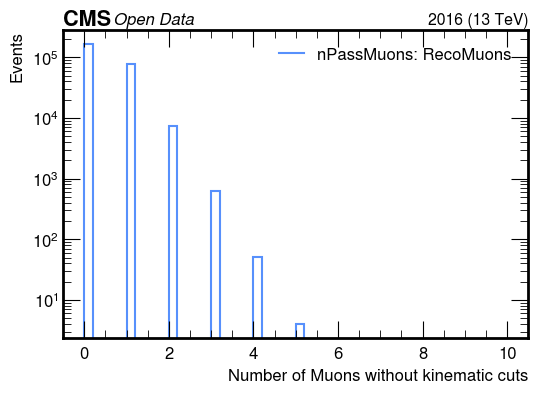

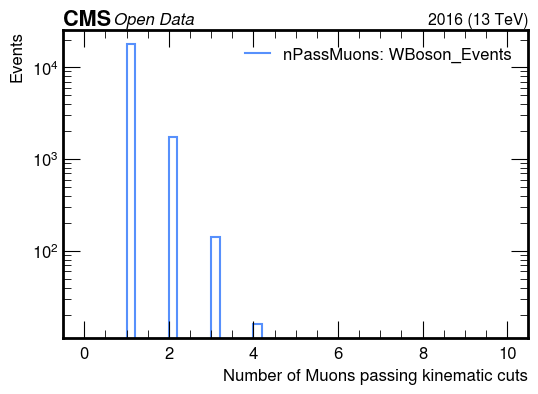

In [56]:
# Number of Muons before any Selection cuts: 
nRecoMuons = dak.num(RecoMuons.pt)
make_hist(
    nRecoMuons,
    50, 0, 10,
    "Number of Muons without kinematic cuts",
    "Events",
    "nPassMuons: RecoMuons",
    fname="Plots/nPassMuons_RecoMuons.png",
    logy=True
)

# WBoson_Events
make_hist(
    nPassMuons,
    50, 0, 10,
    "Number of Muons passing kinematic cuts",
    "Events",
    "nPassMuons: WBoson_Events",
    fname="Plots/nPassMuons_WBoson_Events.png",
    logy=True
)

Let us also plot the kinematic observables of RecoMuons from the collection: `WBoson_Events`.

## Without any Kinematic Cuts:
- Muon $p_{T}$
- Muon $\eta$
- Muon $\phi$
- Muon_pfRelIso04_all
- Muon_TightID

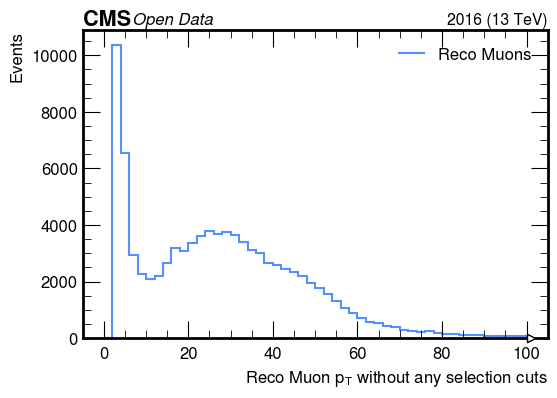

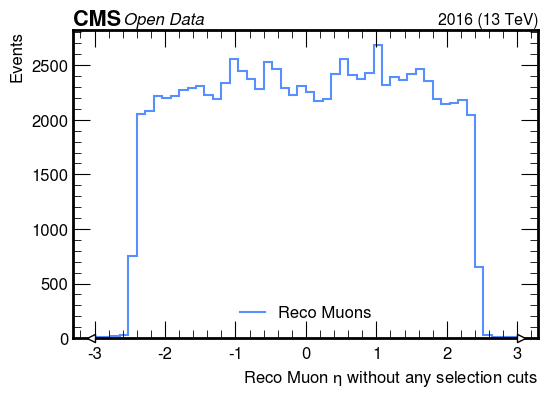

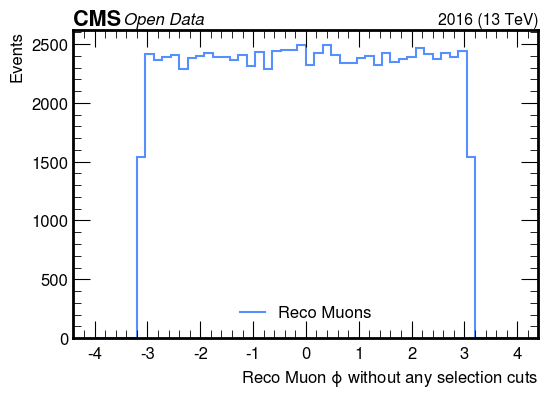

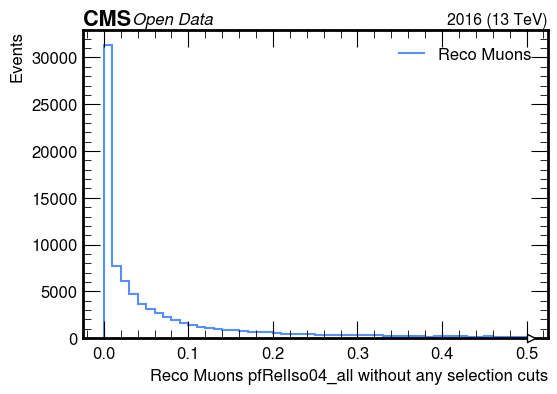

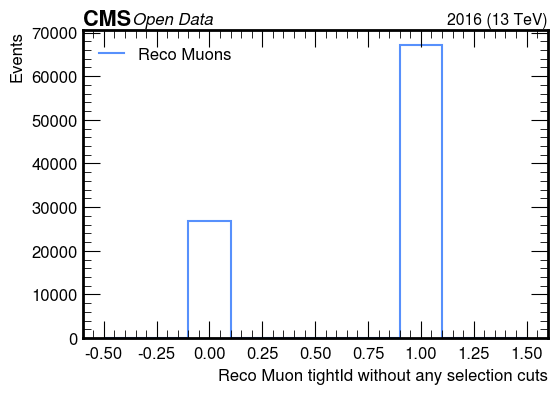

In [57]:
# Muon Pt (without cuts):
Pass_Muon_Pt = dak.flatten(events.Muon.pt)
make_hist(
    Pass_Muon_Pt,
    50, 0, 100,
    "Reco Muon $p_{T}$ without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_Pt.png",
    logy=False
)
# Muon eta (without cuts):
Pass_Muon_Eta = dak.flatten(events.Muon.eta)
make_hist(
    Pass_Muon_Eta,
    50, -3, 3,
    "Reco Muon $\\eta$ without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_Eta.png",
    logy=False
)
# Muon Phi (without cuts):
Pass_Muon_Phi = dak.flatten(events.Muon.phi)
make_hist(
    Pass_Muon_Phi,
    50, -4, 4,
    "Reco Muon $\\phi$ without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_Phi.png",
    logy=False
)
# Muon pfRelIso04_all (without cuts):
Pass_Muon_pfRelIso04 = dak.flatten(events.Muon.pfRelIso04_all)
make_hist(
    Pass_Muon_pfRelIso04,
    50, 0, 0.5,
    "Reco Muons pfRelIso04_all without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_pfRelIso04_all.png"
)
# Muon TightID (without cuts):
Pass_Muon_tightId = dak.flatten(events.Muon.tightId)
make_hist(
    Pass_Muon_tightId,
    10, -0.5, 1.5,
    "Reco Muon tightId without any selection cuts",
    "Events",
    "Reco Muons",
    fname="Plots/WBoson_RecoMuon_tightId.png",
    logy=False
)

## With all Kinematic Cuts:
- Muon $p_{T}$
- Muon $\eta$
- Muon $\phi$
- Muon_pfRelIso04_all
- Muon_TightID

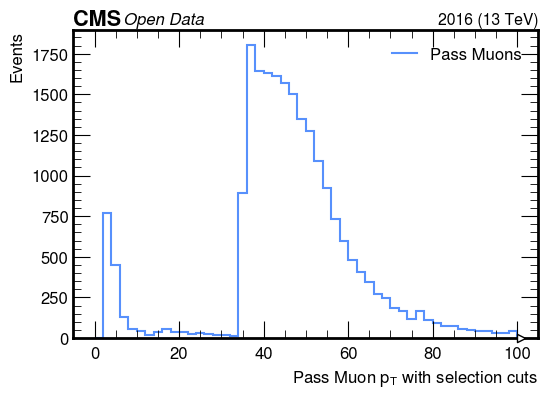

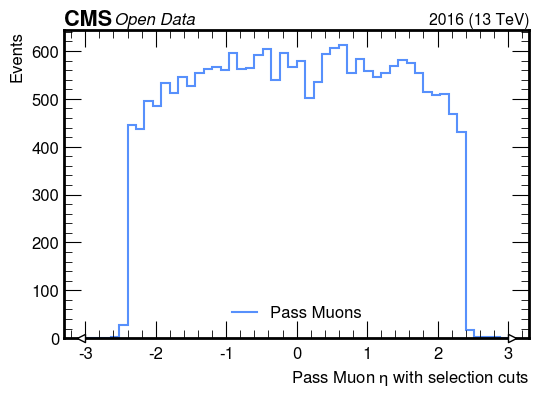

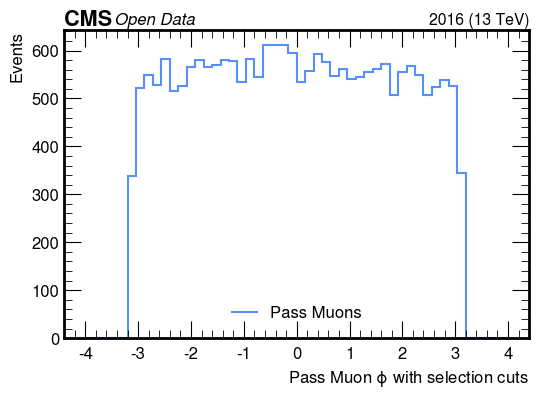

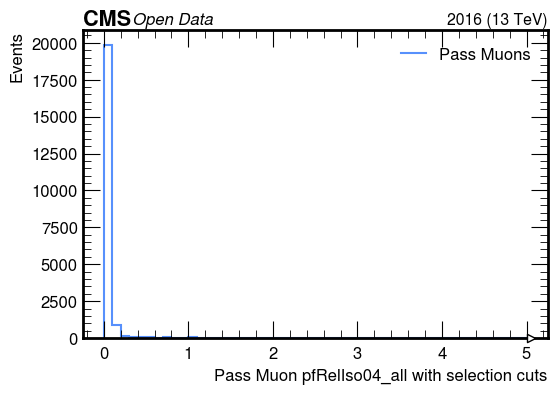

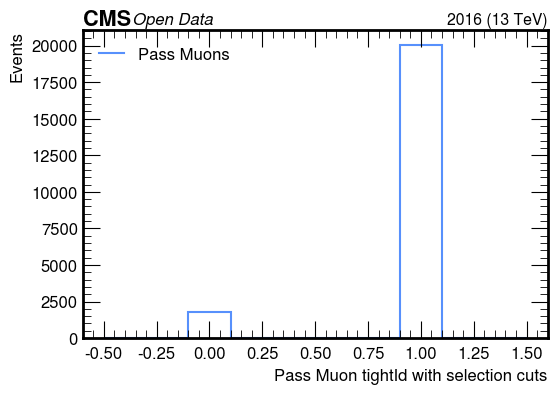

In [58]:
# Muon Pt (with cuts):
Pass_Muon_Pt = dak.flatten(pass_events.Muon.pt)
make_hist(
    Pass_Muon_Pt,
    50, 0, 100,
    "Pass Muon $p_{T}$ with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_Pt.png",
    logy=False
)
# Muon eta (with cuts):
Pass_Muon_Eta = dak.flatten(pass_events.Muon.eta)
make_hist(
    Pass_Muon_Eta,
    50, -3, 3,
    "Pass Muon $\\eta$ with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_Eta.png",
    logy=False
)
# Muon Phi (with cuts):
Pass_Muon_Phi = dak.flatten(pass_events.Muon.phi)
make_hist(
    Pass_Muon_Phi,
    50, -4, 4,
    "Pass Muon $\\phi$ with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_Phi.png",
    logy=False
)
# Muon pfRelIso04_all (with cuts):
Pass_Muon_pfRelIso04_all = dak.flatten(pass_events.Muon.pfRelIso04_all)
make_hist(
    Pass_Muon_pfRelIso04_all,
    50, 0, 5,
    "Pass Muon pfRelIso04_all with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_pfRelIso04_all.png",
    logy=False
)
# Muon tightID (with cuts):
Pass_Muon_tightId = dak.flatten(pass_events.Muon.tightId)
make_hist(
    Pass_Muon_tightId,
    10, -0.5, 1.5,
    "Pass Muon tightId with selection cuts",
    "Events",
    "Pass Muons",
    fname="Plots/WBoson_PassMuon_tightId.png",
    logy=False
)

> **Bug Issue:** Selection Cuts `Sel_Cuts` has an issue. Since, `Sel_Cuts` is jagged boolean mask, so one needs to do `dak.any(Sel_Cuts, axis=1)`. But this makes the Selection cuts not work properly. But after the final selection cuts are done ,i.e. `~OS_Mask` is applied, the cuts work perfectly fine. The occurence of this issue is not understood and needs to be resolved.

## Final Selection with all Kinematic Cuts:
- Muon $p_{T}$
- Muon $\eta$
- Muon $\phi$
- Muon_pfRelIso04_all
- Muon_TightID

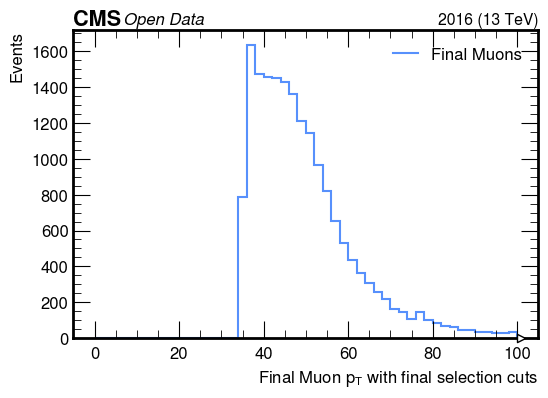

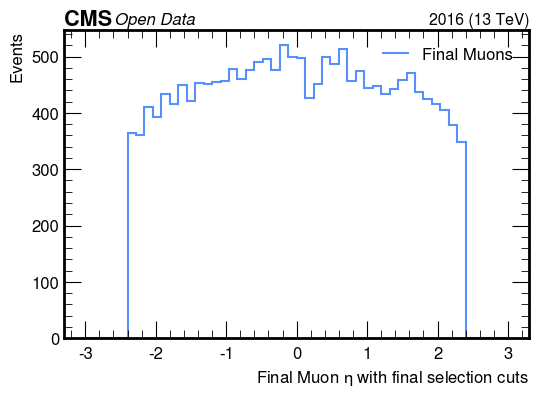

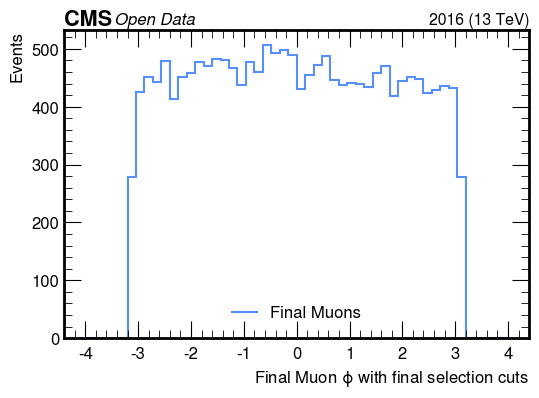

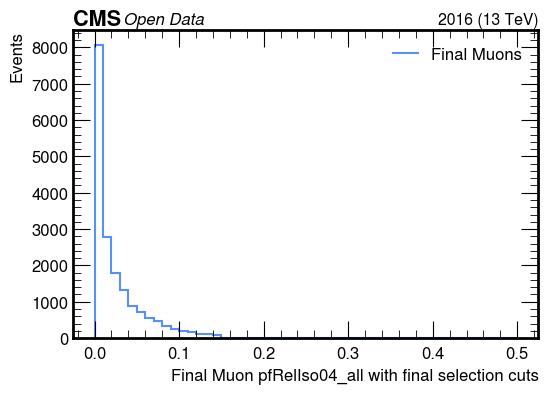

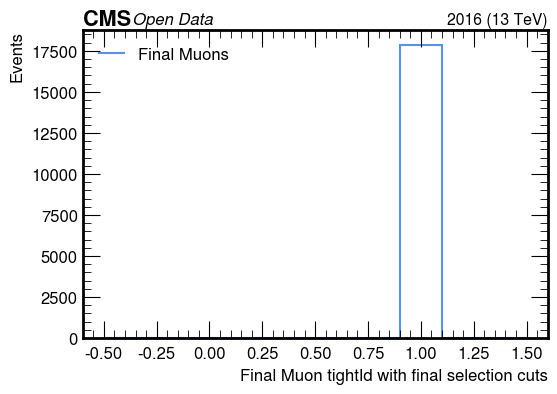

In [59]:
# Muon Pt (with cuts):
WBos_Pass_Muon_Pt = dak.flatten(WBoson_Events.Muon.pt)
make_hist(
    WBos_Pass_Muon_Pt,
    50, 0, 100,
    "Final Muon $p_{T}$ with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_Pt.png",
    logy=False
)
# Muon eta (with cuts):
WBos_Muon_Eta = dak.flatten(WBoson_Events.Muon.eta)
make_hist(
    WBos_Muon_Eta,
    50, -3, 3,
    "Final Muon $\\eta$ with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_Eta.png",
    logy=False
)
# Muon Phi (with cuts):
WBos_Muon_Phi = dak.flatten(WBoson_Events.Muon.phi)
make_hist(
    WBos_Muon_Phi,
    50, -4, 4,
    "Final Muon $\\phi$ with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_Phi.png",
    logy=False
)
# Muon pfRelIso04_all (with cuts):
WBos_Muon_pfRelIso04 = dak.flatten(WBoson_Events.Muon.pfRelIso04_all)
make_hist(
    WBos_Muon_pfRelIso04,
    50, 0, 0.5,
    "Final Muon pfRelIso04_all with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_pfRelIso04_all.png",
    logy=False
)
# Muon tightId (with cuts):
WBos_Muon_tightId = dak.flatten(WBoson_Events.Muon.tightId)
make_hist(
    WBos_Muon_tightId,
    10, -0.5, 1.5,
    "Final Muon tightId with final selection cuts",
    "Events",
    "Final Muons",
    fname="Plots/WBoson_FinalMuon_tightId.png",
    logy=False
)

## Number of Final Selected Muons:
This plot is the number of all selected muons and should only have the events with a single muon.

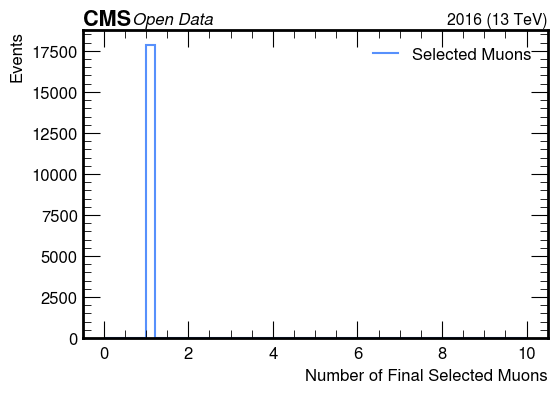

In [60]:
# Plot the number of Muons Final:
WBos_Muon_Pt = WBoson_Events.Muon.pt
nPassMu = dak.num(WBos_Muon_Pt)
make_hist(
    nPassMu,
    50, 0, 10,
    "Number of Final Selected Muons",
    "Events",
    "Selected Muons",
    fname="Plots/nFinalSelectedMuons.png",
    logy=False
)

All events passing these muon selections for W Bosons need to be stored now, so that we can do the **OS - SS** selection.

## c $\rightarrow$ $\mu$ + Anything Event Selection:

This part of the notebook selects all the events that pass the following cuts:
- Jet $p_{T}$ > 30 GeV
- Jet $\eta$ < 2.4
- Muon $p_{T}$ < 25 GeV
- Muon $\eta$ < 2.4
- Muon_pfRelIso04_all > 0.2
- Muon_jetIdx >=0
- Dimuon invariant mass 20 GeV < Inv_Mass $\mu^{+}\mu^{-}$ < 80 GeV.  

In [61]:
# RecoJet Collection:
RecoJets = events.Jet

# Jet Selection Cuts:
Jet_PassCuts = (
    (abs(RecoJets.eta) < 2.4) &
    (RecoJets.pt > 30)
)
selCuts_jet = dak.any(Jet_PassCuts, axis=1)
pass_events_Jets = events[selCuts_jet]

RecoMuons = pass_events_Jets.Muon

# Muon Selection Cuts:
Muon_PassCuts = (
    (abs(RecoMuons.eta) < 2.4) &
    (RecoMuons.pt < 25) &
    (abs(RecoMuons.pfRelIso04_all) > 0.2) &
    (RecoMuons.jetIdx >= 0)
)
selCuts_Muon = dak.any(Muon_PassCuts, axis=1)
pass_events_Muons = pass_events_Jets[selCuts_Muon]

# Jet Muons:
Jet_Muons = pass_events_Muons.Muon

# Dimuon Mass:
Jet_Muons_Padded = dak.pad_none(Jet_Muons, 2, axis=1)
valid_mask = ~dak.is_none(Jet_Muons_Padded[:,0]) & ~dak.is_none(Jet_Muons_Padded[:,1])
dimuon_events = Jet_Muons_Padded[valid_mask]

# Dimuon mass:
dimuon_mass = (dimuon_events[:,0] + dimuon_events[:,1]).mass

# Dimuon mass cut:
mass_Cut = (
    (dimuon_mass > 20) &
    (dimuon_mass < 80)
    )
final_Cut = mass_Cut
Jet_Events = pass_events_Jets[final_Cut]

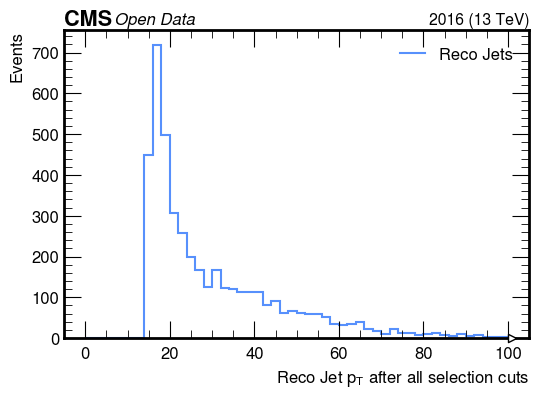

In [62]:
Jet_Pt = dak.flatten(Jet_Events.Jet.pt)
make_hist(
    Jet_Pt,
    50, 0, 100,
    "Reco Jet $p_{T}$ after all selection cuts",
    "Events",
    "Reco Jets",
    fname=None,
    logy=False
)

Plotting the Number of Selected Muons:

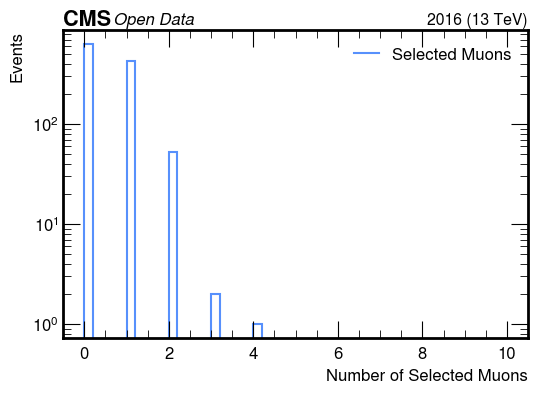

In [63]:
Selected_Muons = Jet_Events.Muon
Selected_Muons_Pt = Selected_Muons.pt
# Number of Muons:
nSelMuons = dak.num(Selected_Muons_Pt)
make_hist(
    nSelMuons,
    50, 0, 10,
    "Number of Selected Muons",
    "Events",
    "Selected Muons",
    fname=None,
    logy=True
)

Plotting the dimuon invariant mass (without putting cuts):

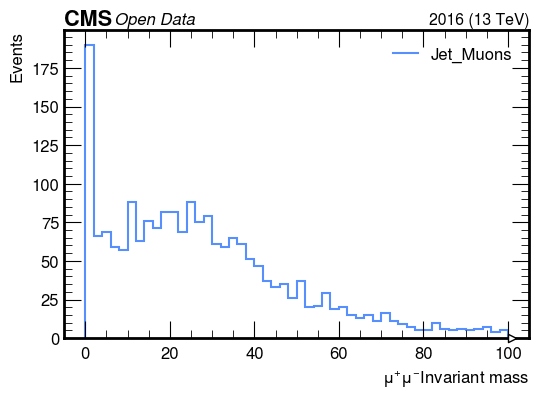

In [64]:
make_hist(
    dimuon_mass,
    50, 0, 100,
    "$\\mu^{+} \\mu^{-}$Invariant mass",
    "Events",
    "Jet_Muons",
    fname=None,
    logy=False
)

Plotting all the kinematic variables before the cut is put:

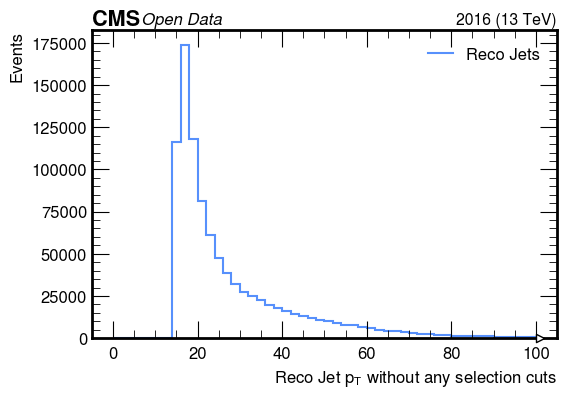

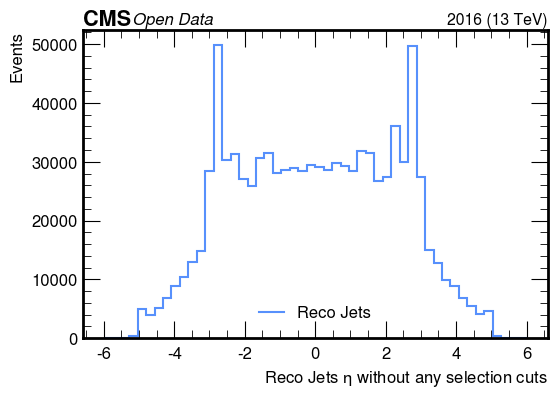

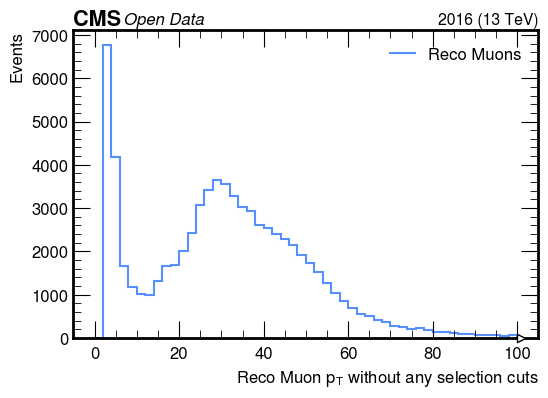

In [65]:
# RecoJet Pt (without cut):
RecoJets_Pt = dak.flatten(RecoJets.pt)
make_hist(
    RecoJets_Pt,
    50, 0, 100,
    "Reco Jet $p_{T}$ without any selection cuts",
    "Events",
    "Reco Jets",
    fname="Plots/RecoJets_pT.png",
    logy=False
) 

# RecoJet Eta (without cut):
RecoJets_eta = dak.flatten(RecoJets.eta)
make_hist(
    RecoJets_eta,
    50, -6, 6,
    "Reco Jets $\\eta$ without any selection cuts",
    "Events",
    "Reco Jets",
    fname="Plots/RecoJets_eta.png",
    logy=False
)

# RecoMuon Pt (without cut):
RecoMuon_Pt = dak.flatten(RecoMuons.pt)
make_hist(
    RecoMuon_Pt,
    50, 0, 100,
    "Reco Muon $p_{T}$ without any selection cuts",
    "Events",
    "Reco Muons",
    fname=None,
    logy=False
) 

Plotting all the kinematic variables after the cut is put:

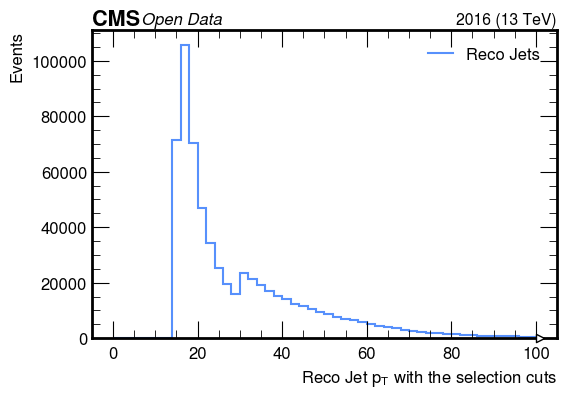

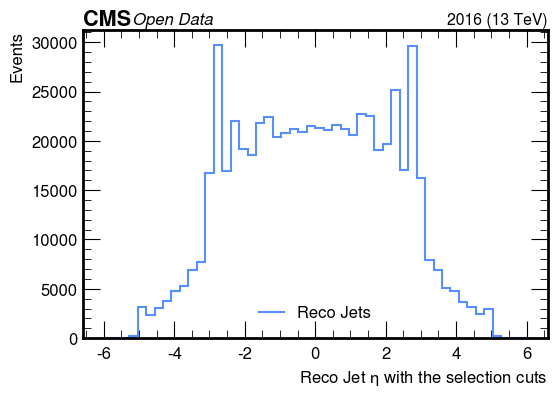

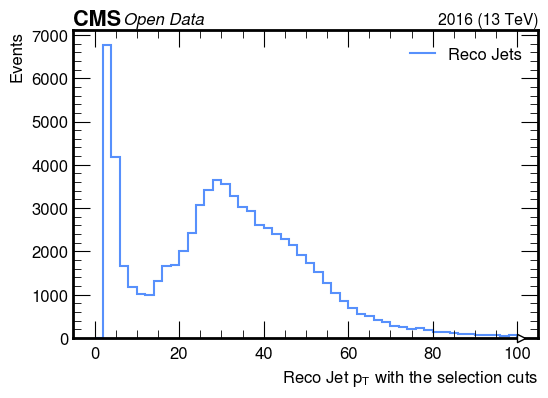

In [66]:
# RecoJet Pt (with cut):
pass_events_Jets_Pt = dak.flatten(pass_events_Jets.Jet.pt)
make_hist(
    pass_events_Jets_Pt,
    50, 0, 100,
    "Reco Jet $p_{T}$ with the selection cuts",
    "Events",
    "Reco Jets",
    fname="Plots/RecoJets_pass_pT.png",
    logy=False
)
# RecoJet Eta (with cut):
pass_events_Jets_eta = dak.flatten(pass_events_Jets.Jet.eta)
make_hist(
    pass_events_Jets_eta,
    50, -6, 6,
    "Reco Jet $\\eta$ with the selection cuts",
    "Events",
    "Reco Jets",
    fname="Plots/RecoJets_pass_eta.png",
    logy=False
)
# RecoMuon Pt (with cut):
pass_events_Jets_Pt = dak.flatten(pass_events_Jets.Muon.pt)
make_hist(
    pass_events_Jets_Pt,
    50, 0, 100,
    "Reco Jet $p_{T}$ with the selection cuts",
    "Events",
    "Reco Jets",
    fname=None,
    logy=False
)

Plotting the final selected Jet and Muons:

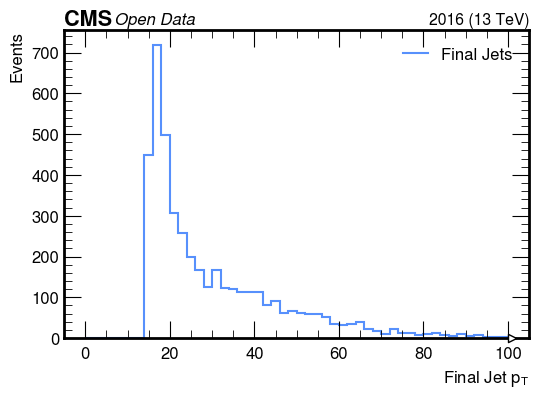

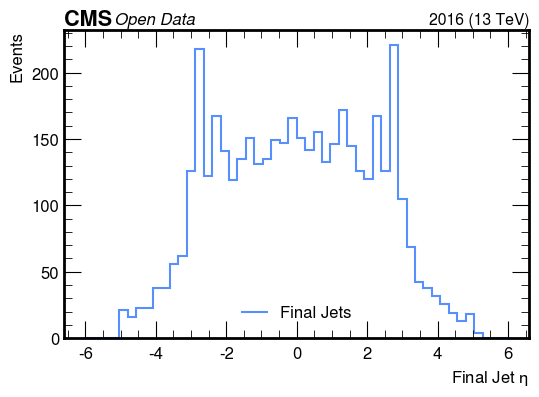

In [67]:
# Jet Pt with final cuts:
Final_Jet_Pt = dak.flatten(Jet_Events.Jet.pt)
make_hist(
    Final_Jet_Pt,
    50, 0, 100,
    "Final Jet $p_{T}$",
    "Events",
    "Final Jets",
    fname="Plots/FinalJet_pT.png",
    logy=False
)

# Jet eta with final cuts:
Final_Jet_eta = dak.flatten(Jet_Events.Jet.eta)
make_hist(
    Final_Jet_eta,
    50, -6, 6,
    "Final Jet $\\eta$",
    "Events",
    "Final Jets",
    fname="Plots/FinalJet_eta.png",
    logy=False
)

>**Bug Issue:** The selection cuts are not being applied. This needs to be fixed.

## OS - SS Analysis (Signal Extraction):

In [68]:
# OS events: Signal-like & SS events: Background-like:

## Debugging Playground:

This is where we will look into bugs and also put solutions to them:

### Bug 1: SOLVED
`dak.any()` on selection cuts makes weird event selections. 

In [69]:
#Reco Muons and Selected Muons:
RecoMuons = events.Muon
GoodMu = dak.num(RecoMuons.pt) > 0
Selection_Cuts = (
    (RecoMuons.pt > 35)
)
Selection_Cuts = dak.any(Selection_Cuts, axis=1)
Selected_Events = events[Selection_Cuts]

Let's plot the Muon $p_{T}$ to see how it behaves with and without the cuts applied with `dak.any()`.

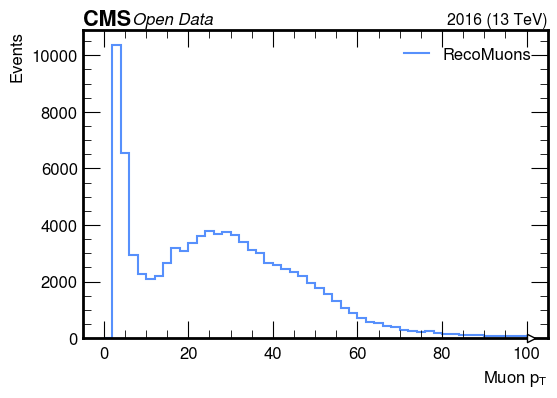

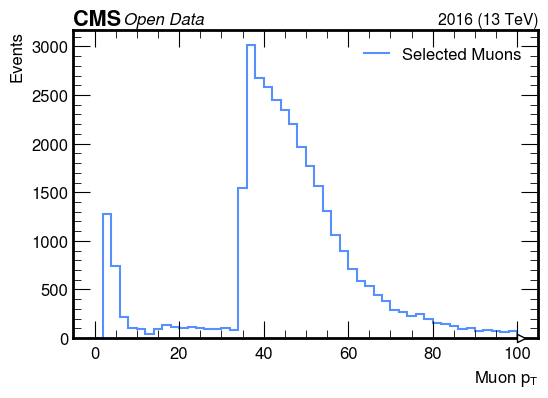

In [70]:
# Muon Pt without any selection cuts:
Muon_Pt = dak.flatten(RecoMuons.pt)
make_hist(
    Muon_Pt,
    50, 0, 100,
    "Muon $p_{T}$",
    "Events",
    "RecoMuons",
    fname=None,
    logy=False
)

# Muon Pt with selection cuts:
Selected_Muon_Pt = dak.flatten(Selected_Events.Muon.pt)
make_hist(
    Selected_Muon_Pt,
    50, 0, 100,
    "Muon $p_{T}$",
    "Events",
    "Selected Muons",
    fname=None,
    logy=False
)

If my guess is correct, this selection cuts:

```python
Selection_Cuts = (
    (RecoMuons.pt > 35)
)
Selection_Cuts = dak.any(Selection_Cuts, axis=1)
Selected_Events = events[Selection_Cuts]
```
This should remove the events that doesn't have a muon that passes the selection cuts. But even if one muon is present in the event which passes the cuts, the event is passed irrespective of other muons not passing the cuts. We don't want that. We want to do this other way around: If even a single muon doesn't pass the cut, discard that muon and the event associated with it. Now that I write this, it is sounding a little counter-intuitive to me. This selection of only events with **Good Muons** will reduce the number of effective events (which is exactly what was happening before). 

To solve this I shall make a boolean mask of Good Muons and pass the events to see if that works (If an event has even one muon that doesn't pass the cuts, discard that):


In [101]:
Selection_Cuts = (
    (RecoMuons.pt > 35) 
)
Selection_Cuts = dak.any(Selection_Cuts, axis=1)
Selected_Events = events[Selection_Cuts]

nPassMuons = dak.num(Selected_Events.Muon.pt, axis=1)
final_Cuts = (nPassMuons == 1)
pass_events = Selected_Events[final_Cuts]

The above snippet does the following:
- Selects events with at least one muon with `Pt > 35` via `dak.any(...)`.
- Counts the total number of muons in those events `(dak.num(Selected_Events.Muon.pt, axis=1))` and keeps events with exactly one muon `(final_Cuts == 1)`.

This has a fundamental logic flaw: The `dak.num(...)` counts every muons in the events and not only the ones that pass. So we need to make a mask of that. 

In [107]:
Muon_Mask = (RecoMuons.pt > 35)
nMuons = dak.all(Muon_Mask, axis=1)

final_mask = (nMuons > 0)
pass_events = events[final_mask]

The above snippet makes a mask of the selection cuts on the muons. The `dak.all(...)` makes a strict cut on all muons in an event and passes those events where every muon must pass the cut. 

Let's plot the Muon $p_{T}$ now:

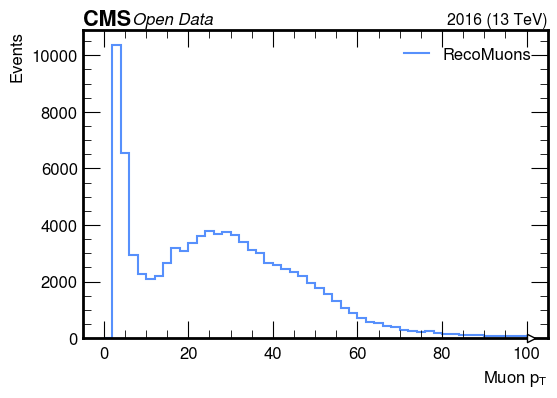

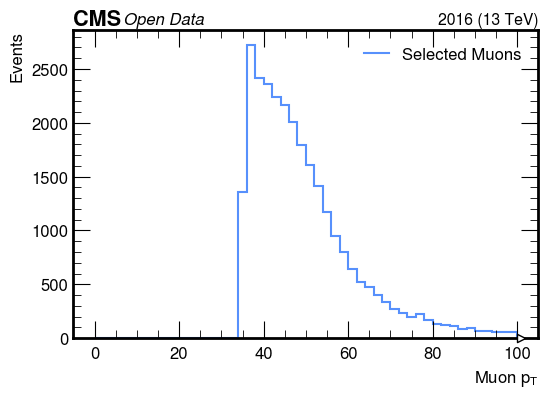

In [109]:
# Muon Pt without any selection cuts:
Muon_Pt = dak.flatten(RecoMuons.pt)
make_hist(
    Muon_Pt,
    50, 0, 100,
    "Muon $p_{T}$",
    "Events",
    "RecoMuons",
    fname=None,
    logy=False
)
# Muon Pt with selection cuts:
Selected_Muon_Pt = dak.flatten(pass_events.Muon.pt)
make_hist(
    Selected_Muon_Pt,
    50, 0, 100,
    "Muon $p_{T}$",
    "Events",
    "Selected Muons",
    fname=None,
    logy=False
)

Whereas, if I just make a collection of Muons and put the selection cuts on them, it should bring all the events which are associated to each passing muon (**Good Muon**). That should work.  